In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
import cv2 as cv
import torchlayers as tl
import os

In [5]:
trans = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor()])
trans_gray = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor(), transforms.Grayscale()])


datas = torchvision.datasets.ImageFolder(root = './data/kcar/darks', transform = trans)
train_size = int(len(datas) * 0.8)
test_size = len(datas) - train_size
train_sets, test_sets = torch.utils.data.random_split(datas, [train_size, test_size])

# edge_datas = torchvision.datasets.ImageFolder(root = './data/kcar_edge/lights', transform = trans_gray)
# edge_train_size = int(len(edge_datas) * 0.8)
# edge_test_size = len(edge_datas) - edge_train_size
# edge_train_sets, edge_test_sets = torch.utils.data.random_split(edge_datas, [edge_train_size, edge_test_size])

edge_train_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/lights', transform = trans)
# edge_test_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/darks', transform = trans)
# train_sets = torchvision.datasets.ImageFolder(root = './data/kcar/lights', transform = trans)
# test_sets = torchvision.datasets.ImageFolder(root = './data/kcar/darks', transform = trans)
labels = datas.classes
# print(len(edge_train_sets))
# print(len(edge_test_sets))
print(len(train_sets))
print(len(test_sets))
print(len(labels))
# print(test_sets)
# print(edge_test_sets)

# print(len(labels))
# for i in range(4):
#     img, label = train_sets[i]
#     print(labels[label])
#     plt.subplot(241 + i)
#     plt.imshow(np.clip(img.permute(1,2,0),0,1))
#     plt.tight_layout()
#     plt.show()
    # save_image(img, str(i)+'_.jpg')


26757
6690
51


In [8]:
# DataLoader 정의 - data 길이 달라지면 random_t_list 수정하기!
import random
random_train_list = list(range(1, len(train_sets)))
random.shuffle(random_train_list)
random_test_list = list(range(1, len(test_sets)))
random.shuffle(random_test_list)

train_loader = DataLoader(train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
# edge_train_loader = DataLoader(edge_train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
print(len(train_loader))
test_loader = DataLoader(test_sets, batch_size = 32, sampler = random_test_list)
# edge_test_loader = DataLoader(edge_test_sets, batch_size = 32, sampler = random_test_list)

837


In [9]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
 
        _, pred = output.topk(maxk, 1, True, True) #(52, 32)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) # (5,32)
 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [10]:
resnet101 = torchvision.models.resnet101(pretrained=True)
resnet101 = resnet101.cuda()

In [11]:
#모델 학습
print(len(train_loader))
print(len(test_loader))

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet101.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6,8], gamma=0.1)
# learning_rate = 1e-4
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# hyper-parameters
num_epochs = 10
num_batches = 32

resnet101.train()
trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_loader):
        x, label = data

        x = x.cuda()
        label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = resnet101(x)               
        _, predicted = torch.max(model_output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        
        # 학습과정 출력
        if (i+1) % 100 == 1: # every 100 mini-batches
            resnet101.eval()
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                val_total = 0
                val_correct = 0
                for j, (val) in enumerate(test_loader):
                    val_x, val_label = val
                    val_x = val_x.cuda()
                    val_label =val_label.cuda()

                    val_output = resnet101(val_x)
                    _, predicted = torch.max(val_output.data, 1)
                    val_total += val_label.size(0)
                    val_correct += (predicted == val_label).sum().item()
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    if epoch < 3:
                        break
                print("----------------testing data: "+ str(j * len(test_loader)))
                acc1, acc5 = accuracy(model_output, label, topk=(1, 5))
                print("train acc1 : {}, acc5 : {}".format(acc1[0], acc5[0])) 
                print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

                acc1, acc5 = accuracy(val_output, val_label, topk=(1, 5))
                print("test acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
                print('Accuracy of the network on the test images: %d %%' % (100 * val_correct / val_total))
                       
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, len(train_loader), trn_loss / len(train_loader), val_loss / len(test_loader)
            ))
                    
            
            trn_loss_list.append(trn_loss/len(train_loader))
            val_loss_list.append(val_loss/len(test_loader))
            trn_loss = 0.0
            resnet101.train()
        
        # del (memory issue)
        # del lossadw
        del model_output
    scheduler.step()
#plotting the loss chart 

837
210
----------------testing data: 0
train acc1 : 0.0, acc5 : 0.0
Accuracy of the network on the train images: 0 %
test acc1 : 3.125, acc5 : 15.625
Accuracy of the network on the test images: 3 %
epoch: 1/10 | step: 1/837 | trn loss: 0.0124 | val loss: 4527177.5000
----------------testing data: 0
train acc1 : 3.125, acc5 : 34.375
Accuracy of the network on the train images: 5 %
test acc1 : 0.0, acc5 : 12.5
Accuracy of the network on the test images: 0 %
epoch: 1/10 | step: 101/837 | trn loss: 0.5367 | val loss: 0.0191
----------------testing data: 0
train acc1 : 6.25, acc5 : 28.125
Accuracy of the network on the train images: 5 %
test acc1 : 3.125, acc5 : 28.125
Accuracy of the network on the test images: 3 %
epoch: 1/10 | step: 201/837 | trn loss: 0.4571 | val loss: 0.0187
----------------testing data: 0
train acc1 : 0.0, acc5 : 21.875
Accuracy of the network on the train images: 5 %
test acc1 : 3.125, acc5 : 28.125
Accuracy of the network on the test images: 3 %
epoch: 1/10 | step

In [18]:
resnet101.eval()
with torch.no_grad(): # very very very very important!!!
    
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    for j, (val) in enumerate(edge_test_loader):
        val_x, val_label = val
        val_x = val_x.cuda()
        val_label =val_label.cuda()
        val_output = resnet101(val_x)
        _, predicted = torch.max(val_output.data, 1)
        val_total += val_label.size(0)
        val_correct += (predicted == val_label).sum().item()
        v_loss = criterion(val_output, val_label)
        val_loss += v_loss
    print("----------------testing data: "+ str(j * len(test_loader)))
    acc1, acc5 = accuracy(val_output, val_label, topk=(1, 5))
    print("test acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
    print('Accuracy of the network on the test images: %d %%' % (100 * val_correct / val_total))
                       

----------------testing data: 70490
test acc1 : 8.333333015441895, acc5 : 16.66666603088379
Accuracy of the network on the test images: 2 %


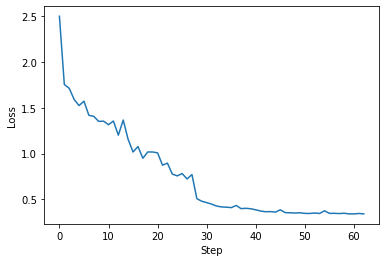

In [21]:
val = []
for l in val_loss_list:
    val.append(l.cpu())
plt.plot(val[27:])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

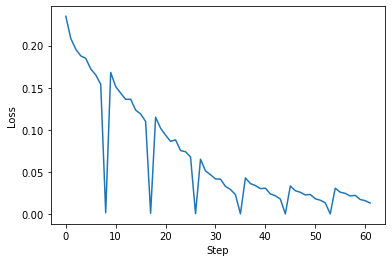

In [23]:
plt.plot(trn_loss_list[28:])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

In [24]:
#모델 저장
torch.save(resnet101, 'resnet_whole_img_89%.pt')
# model1 = torch.load('model1.pt')